<a href="https://colab.research.google.com/github/JagpreetJakhar/Assignments/blob/main/SML/Q1_SML_acq22jj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 23.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=246fba3e04e26ed8f63df01f98bf61ec49be967f3e633259ac5a78be24f56fbb
  Stored in directory: /root/.cache/pip/wheels/0f/f0/3d/517368b8ce80486e84f89f214e0a022554e4ee64969f46279b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [554]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import desc
import pandas as pd
from pyspark.sql.functions import substring

In [ ]:
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Assignment") \
    .config("spark.local.dir","/fastdata/acq22jj") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("WARN")  # This can only affect the log level after it is executed.

In [ ]:
spark

In [555]:
log_raw = spark.read.text('/content/drive/MyDrive/Data/NASA_access_log_Jul95.gz').cache()

In [556]:
log_raw.show(7,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
|burger.letters.com - - 

In [557]:
log_file_fmt = log_raw.withColumn('host', F.regexp_extract('value', '^(.*) - -.*', 1)) \
                .withColumn('timestamp', F.regexp_extract('value', '.* - - \[(.*)\].*',1)) \
                .withColumn('request', F.regexp_extract('value', '.*\"(.*)\".*',1)) \
                .withColumn('HTTP reply code', F.split('value', ' ').getItem(F.size(F.split('value', ' ')) -2).cast("int")) \
                .withColumn('bytes in the reply', F.split('value', ' ').getItem(F.size(F.split('value', ' ')) - 1).cast("int")).drop("value").cache()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/column.py:419: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [558]:
log_file_fmt.show(5,truncate = False)

+--------------------+--------------------------+------------------------------------------------------------+---------------+------------------+
|host                |timestamp                 |request                                                     |HTTP reply code|bytes in the reply|
+--------------------+--------------------------+------------------------------------------------------------+---------------+------------------+
|199.72.81.55        |01/Jul/1995:00:00:01 -0400|GET /history/apollo/ HTTP/1.0                               |200            |6245              |
|unicomp6.unicomp.net|01/Jul/1995:00:00:06 -0400|GET /shuttle/countdown/ HTTP/1.0                            |200            |3985              |
|199.120.110.21      |01/Jul/1995:00:00:09 -0400|GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0   |200            |4085              |
|burger.letters.com  |01/Jul/1995:00:00:11 -0400|GET /shuttle/countdown/liftoff.html HTTP/1.0                |304           

In [559]:
hosts_de = log_file_fmt.filter(log_file_fmt['host'].endswith('.de')).cache()

In [560]:
hosts_de.show(5,truncate=False)


+--------------------------------+--------------------------+-----------------------------------------+---------------+------------------+
|host                            |timestamp                 |request                                  |HTTP reply code|bytes in the reply|
+--------------------------------+--------------------------+-----------------------------------------+---------------+------------------+
|modem1.castrop-rauxel.netsurf.de|01/Jul/1995:02:32:12 -0400|GET / HTTP/1.0                           |200            |7074              |
|modem1.castrop-rauxel.netsurf.de|01/Jul/1995:02:32:13 -0400|GET /images/ksclogo-medium.gif HTTP/1.0  |200            |5866              |
|modem1.castrop-rauxel.netsurf.de|01/Jul/1995:02:32:16 -0400|GET /images/NASA-logosmall.gif HTTP/1.0  |200            |786               |
|modem1.castrop-rauxel.netsurf.de|01/Jul/1995:02:32:16 -0400|GET /images/MOSAIC-logosmall.gif HTTP/1.0|200            |363               |
|modem1.castrop-rauxel.nets

In [561]:
hosts_ca = log_file_fmt.filter(log_file_fmt['host'].endswith('.ca')).cache()

In [562]:
hosts_ca.show(5,truncate=False)


+-------------------------+--------------------------+--------------------------------------------------------------+---------------+------------------+
|host                     |timestamp                 |request                                                       |HTTP reply code|bytes in the reply|
+-------------------------+--------------------------+--------------------------------------------------------------+---------------+------------------+
|remote27.compusmart.ab.ca|01/Jul/1995:00:01:14 -0400|GET /shuttle/missions/sts-71/sts-71-patch-small.gif HTTP/1.0  |200            |12054             |
|remote27.compusmart.ab.ca|01/Jul/1995:00:01:27 -0400|GET /shuttle/countdown/ HTTP/1.0                              |200            |3985              |
|remote27.compusmart.ab.ca|01/Jul/1995:00:01:53 -0400|GET /cgi-bin/imagemap/countdown?102,174 HTTP/1.0              |302            |110               |
|remote27.compusmart.ab.ca|01/Jul/1995:00:01:55 -0400|GET /shuttle/missions/sts-71

In [563]:
hosts_sg = log_file_fmt.filter(log_file_fmt['host'].endswith('.sg')).cache()

In [564]:
hosts_sg.show(5,truncate=False)


+------------------------+--------------------------+------------------------------------------------+---------------+------------------+
|host                    |timestamp                 |request                                         |HTTP reply code|bytes in the reply|
+------------------------+--------------------------+------------------------------------------------+---------------+------------------+
|ts900-418.singnet.com.sg|01/Jul/1995:00:50:09 -0400|GET /shuttle/countdown/ HTTP/1.0                |200            |3985              |
|ts900-418.singnet.com.sg|01/Jul/1995:00:50:13 -0400|GET /shuttle/countdown/count.gif HTTP/1.0       |200            |40310             |
|ts900-418.singnet.com.sg|01/Jul/1995:00:50:13 -0400|GET /images/NASA-logosmall.gif HTTP/1.0         |200            |786               |
|ts900-418.singnet.com.sg|01/Jul/1995:00:50:13 -0400|GET /images/KSC-logosmall.gif HTTP/1.0          |200            |1204              |
|ts900-418.singnet.com.sg|01/Jul/1

In [565]:
hosts_de.count(),hosts_ca.count(),hosts_sg.count()

(21345, 58290, 1057)

In [566]:
counts = [hosts_de.count(),hosts_ca.count(),hosts_sg.count()]

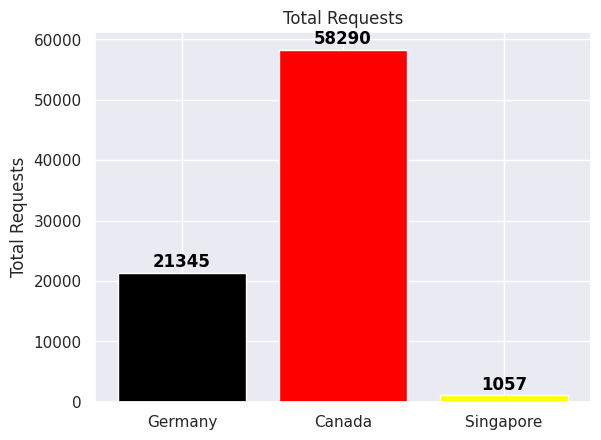

In [567]:
range = np.arange(len(counts))
colors = ['black', 'red', 'yellow']
plt.bar(range,counts,color=colors)
plt.xticks(range, ['Germany', 'Canada', 'Singapore'])
for i, v in enumerate(counts):
    plt.text(i, v + 1000, str(v), color='black', ha='center', fontweight='bold')
plt.title('Total Requests')
plt.ylabel('Total Requests')
plt.savefig('Output/Q1_A.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [568]:
unique_de = hosts_de.select('host').distinct().count()

In [569]:
unique_ca = hosts_ca.select('host').distinct().count()

In [570]:
unique_sg = hosts_sg.select('host').distinct().count()

In [571]:
unique_de,unique_ca,unique_sg

(1138, 2970, 78)

In [572]:
frequent_de = hosts_de.select('host').groupBy('host').count().sort('count', ascending=False)

In [573]:
frequent_de = frequent_de.withColumnRenamed("host", "Germany")

In [574]:
frequent_ca = hosts_ca.select('host').groupBy('host').count().sort('count', ascending=False)

In [575]:
frequent_ca = frequent_ca.withColumnRenamed("host", "Canada")

In [576]:
frequent_sg = hosts_sg.select('host').groupBy('host').count().sort('count', ascending=False)

In [577]:
frequent_sg = frequent_sg.withColumnRenamed("host", "Singapore")

In [578]:
frequent_de.show(truncate=False),frequent_ca.show(truncate=False),frequent_sg.show(truncate=False)

+---------------------------------------+-----+
|Germany                                |count|
+---------------------------------------+-----+
|host62.ascend.interop.eunet.de         |832  |
|aibn32.astro.uni-bonn.de               |642  |
|ns.scn.de                              |523  |
|www.rrz.uni-koeln.de                   |423  |
|ztivax.zfe.siemens.de                  |387  |
|sun7.lrz-muenchen.de                   |280  |
|relay.ccs.muc.debis.de                 |275  |
|dws.urz.uni-magdeburg.de               |244  |
|relay.urz.uni-heidelberg.de            |239  |
|host8.ascend.interop.eunet.de          |233  |
|info3.rus.uni-stuttgart.de             |231  |
|intospa.aball.de                       |219  |
|bombasto.informatik.rwth-aachen.de     |213  |
|sbusol.rz.uni-sb.de                    |197  |
|alpc6.mpimf-heidelberg.mpg.de          |197  |
|prakinf2.prakinf.tu-ilmenau.de         |197  |
|toro.neuroinformatik.ruhr-uni-bochum.de|190  |
|www.sni.de                             

(None, None, None)

In [579]:
top9_de = frequent_de.limit(9)

In [580]:
top9_ca = frequent_ca.limit(9)

In [581]:
top9_sg = frequent_sg.limit(9)

In [582]:
top9_de.show(truncate=False),top9_ca.show(truncate=False),top9_sg.show(truncate=False)

+------------------------------+-----+
|Germany                       |count|
+------------------------------+-----+
|host62.ascend.interop.eunet.de|832  |
|aibn32.astro.uni-bonn.de      |642  |
|ns.scn.de                     |523  |
|www.rrz.uni-koeln.de          |423  |
|ztivax.zfe.siemens.de         |387  |
|sun7.lrz-muenchen.de          |280  |
|relay.ccs.muc.debis.de        |275  |
|dws.urz.uni-magdeburg.de      |244  |
|relay.urz.uni-heidelberg.de   |239  |
+------------------------------+-----+

+--------------------------+-----+
|Canada                    |count|
+--------------------------+-----+
|ottgate2.bnr.ca           |1718 |
|freenet.edmonton.ab.ca    |782  |
|bianca.osc.on.ca          |511  |
|alize.ere.umontreal.ca    |479  |
|pcrb.ccrs.emr.ca          |461  |
|srv1.freenet.calgary.ab.ca|362  |
|ccn.cs.dal.ca             |351  |
|oncomdis.on.ca            |304  |
|cobain.arcs.bcit.bc.ca    |289  |
+--------------------------+-----+

+-------------------------+-----+
|S

(None, None, None)

In [583]:
rest_de = frequent_de.exceptAll(top9_de)

In [584]:
rest_ca = frequent_ca.exceptAll(top9_ca)

In [585]:
rest_sg = frequent_sg.exceptAll(top9_sg)

In [586]:
rest_de.show(truncate=False),rest_ca.show(truncate=False),rest_sg.show(truncate=False)

+---------------------------------+-----+
|Germany                          |count|
+---------------------------------+-----+
|ppp4.hrz.uni-bielefeld.de        |25   |
|yorktown.physik.uni-osnabrueck.de|16   |
|odyssey.med-ph.uni-sb.de         |9    |
|gimli.astro.uni-jena.de          |9    |
|kubi4.informatik.uni-bremen.de   |6    |
|pcip1.uni-duisburg.de            |3    |
|papaya.dbresearch-berlin.de      |3    |
|osi.belwue.de                    |2    |
|sun24.tfh-berlin.de              |36   |
|x0000c04043a2.uni-passau.de      |6    |
|elrond.astro.uni-jena.de         |5    |
|pci03.chemie2.uni-rostock.de     |4    |
|inf-pc43.fbm.htw-kempten.de      |1    |
|ifr14.luftfahrt.uni-stuttgart.de |1    |
|blacky.tp4.ruhr-uni-bochum.de    |1    |
|rod1817.dvz.fh-aachen.de         |32   |
|dialslip-17.rz.ruhr-uni-bochum.de|8    |
|iagrs04.iag.uni-stuttgart.de     |5    |
|eeetw9.et.tu-dresden.de          |4    |
|ax1309.physik.uni-marburg.de     |2    |
+---------------------------------

(None, None, None)

In [587]:
rest_total_de = rest_de.agg({"count": "sum"}).collect()[0][0]

In [588]:
rest_total_ca = rest_ca.agg({"count": "sum"}).collect()[0][0]

In [589]:
rest_total_sg = rest_sg.agg({"count": "sum"}).collect()[0][0]

In [590]:
rest_total_de,rest_total_ca,rest_total_sg

(17500, 53033, 527)

In [591]:
top9_de_pd = top9_de.toPandas()

In [592]:
top9_de_pd.loc[9] = ['Rest', rest_total_de]

In [593]:
top9_ca_pd = top9_ca.toPandas()

In [594]:
top9_sg_pd = top9_sg.toPandas()

In [595]:
top9_ca_pd.loc[9] = ['Rest', rest_total_ca]

In [596]:
top9_sg_pd.loc[9] = ['Rest', rest_total_sg]

In [597]:
top9_de_pd,top9_ca_pd,top9_sg_pd

(                          Germany  count
 0  host62.ascend.interop.eunet.de    832
 1        aibn32.astro.uni-bonn.de    642
 2                       ns.scn.de    523
 3            www.rrz.uni-koeln.de    423
 4           ztivax.zfe.siemens.de    387
 5            sun7.lrz-muenchen.de    280
 6          relay.ccs.muc.debis.de    275
 7        dws.urz.uni-magdeburg.de    244
 8     relay.urz.uni-heidelberg.de    239
 9                            Rest  17500,
                        Canada  count
 0             ottgate2.bnr.ca   1718
 1      freenet.edmonton.ab.ca    782
 2            bianca.osc.on.ca    511
 3      alize.ere.umontreal.ca    479
 4            pcrb.ccrs.emr.ca    461
 5  srv1.freenet.calgary.ab.ca    362
 6               ccn.cs.dal.ca    351
 7              oncomdis.on.ca    304
 8      cobain.arcs.bcit.bc.ca    289
 9                        Rest  53033,
                    Singapore  count
 0     merlion.singnet.com.sg    308
 1             sunsite.nus.sg     40
 2     

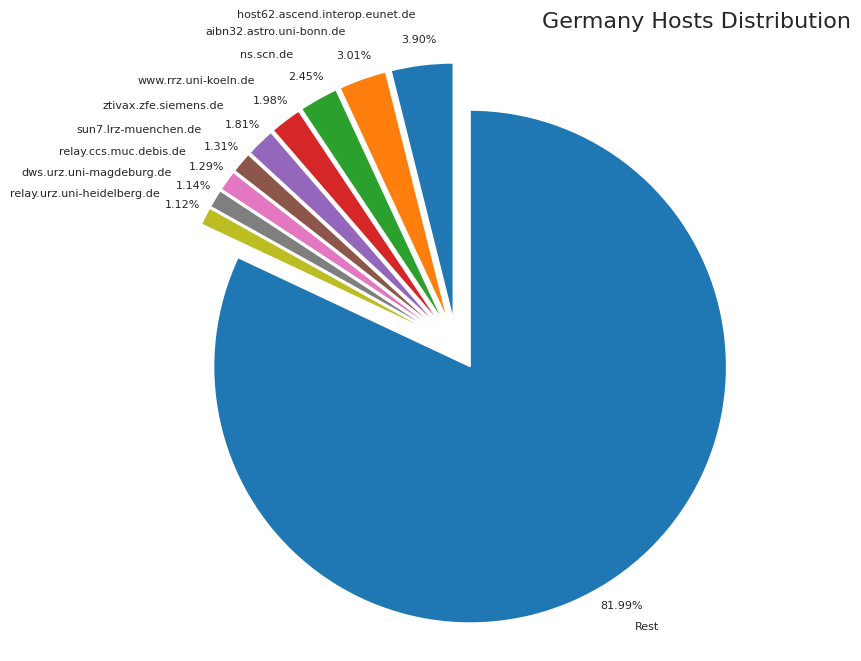

In [598]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

# create the chart
plt.pie(top9_de_pd['count'], labels=top9_de_pd['Germany'], autopct='%1.2f%%', explode=[0.1]*len(top9_de_pd),
        startangle=90, colors=colors, textprops={'fontsize': 8},pctdistance=1.1, labeldistance=1.2)

# add a title
plt.title('Germany Hosts Distribution', fontsize=16,loc='right')

# remove legend
plt.legend().remove()

# set equal axis
plt.axis('equal')

# set size of the chart
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.savefig('Output/Q1_C_Ger.png', dpi=400,bbox_inches='tight')

# show the chart
plt.show()

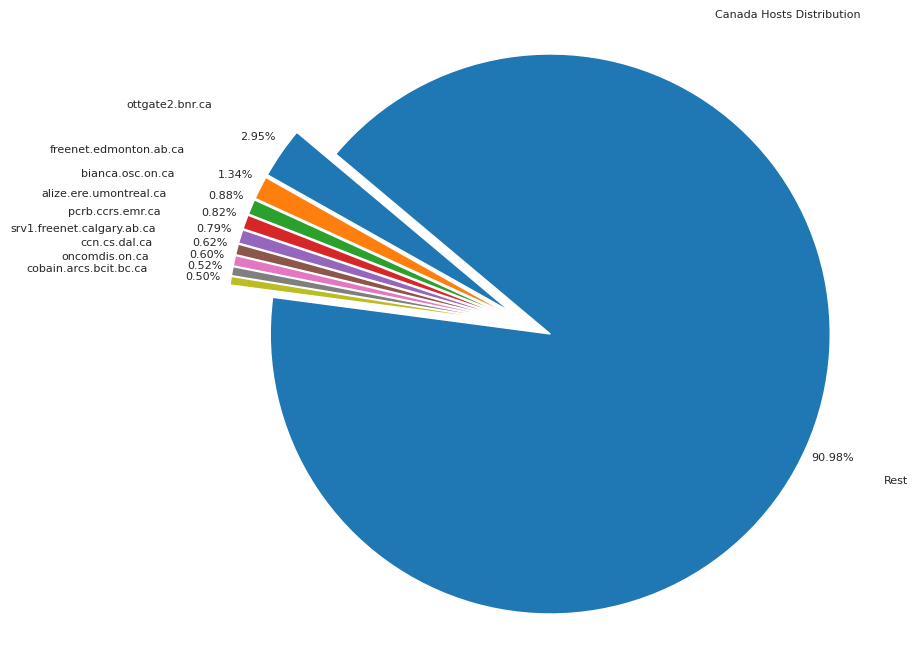

In [599]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

# create the chart
plt.pie(top9_ca_pd['count'], labels=top9_ca_pd['Canada'], autopct='%1.2f%%', explode=[0.08]*len(top9_ca_pd),
        startangle=140, colors=colors,textprops={'fontsize': 8},pctdistance=1.1, labeldistance=1.3)

# add a title
plt.title('Canada Hosts Distribution', fontsize=8,loc='right')

# remove legend
plt.legend().remove()

# set equal axis
plt.axis('scaled')

# set size of the chart
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.savefig('Output/Q1_C_Can.png', dpi=400,bbox_inches='tight')

# show the chart
plt.show()

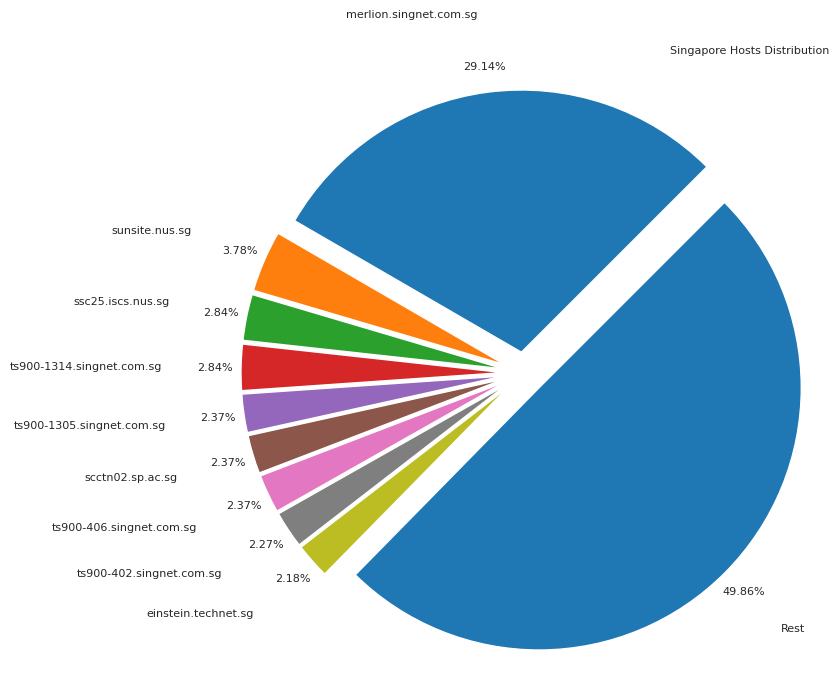

In [600]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

# create the chart
plt.pie(top9_sg_pd['count'], labels=top9_sg_pd['Singapore'], autopct='%1.2f%%', explode=[0.08]*len(top9_sg_pd),
        startangle=45, colors=colors,textprops={'fontsize': 8},pctdistance=1.1, labeldistance=1.3)

# add a title
plt.title('Singapore Hosts Distribution', fontsize=8,loc='right')

# remove legend
plt.legend().remove()

# set equal axis
plt.axis('scaled')

# set size of the chart
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.savefig('Output/Q1_C_Sing.png', dpi=400,bbox_inches='tight')

# show the chart
plt.show()

In [601]:
# group by host and count the number of occurrences
host_counts_de = hosts_de.select('host').groupBy('host').count().sort(desc('count'))

# extract the most frequent host
most_frequent_host_de = host_counts_de.first()['host']

# filter the original DataFrame based on the most frequent host
most_frequent_host_visits_de = hosts_de.filter(hosts_de['host'] == most_frequent_host_de)

# extract the times and hours of the visits
times_and_hours_de =most_frequent_host_visits_de.select(substring('timestamp', 1, 2).alias('day'), substring('timestamp', 13, 2).alias('hour'))

date_hours_pd_de = times_and_hours_de.toPandas()

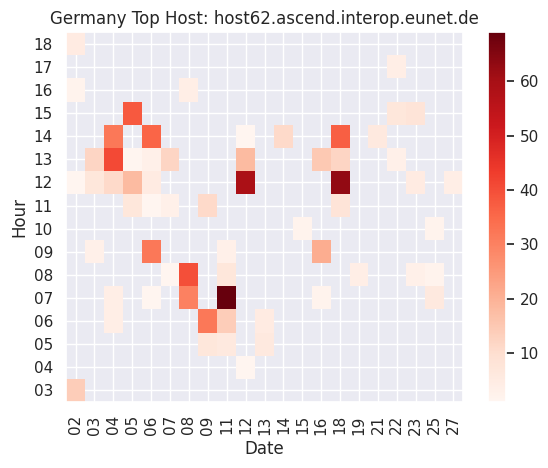

In [602]:
# count the number of visits on each date-hour combination
counts_de = date_hours_pd_de.groupby(['day', 'hour']).size().reset_index(name='count')

# create pivot table for heatmap
heatmap_data_de = pd.pivot_table(counts_de, values='count', index=['hour'], columns=['day'])

# plot heatmap
plt.pcolormesh(heatmap_data_de, cmap='Reds')
plt.colorbar()
plt.title(f'Germany Top Host: {most_frequent_host_de}')
plt.xlabel('Date')
plt.ylabel('Hour')
plt.xticks(np.arange(0.5, len(heatmap_data_de.columns), 1), heatmap_data_de.columns, rotation=90)
plt.yticks(np.arange(0.5, len(heatmap_data_de.index), 1), heatmap_data_de.index)
plt.savefig('Output/Q1_D_Ger.png', dpi=400,bbox_inches='tight')
plt.show()

In [603]:
# group by host and count the number of occurrences
host_counts_ca = hosts_ca.select('host').groupBy('host').count().sort(desc('count'))

# extract the most frequent host
most_frequent_host_ca = host_counts_ca.first()['host']

# filter the original DataFrame based on the most frequent host
most_frequent_host_visits_ca = hosts_ca.filter(hosts_ca['host'] == most_frequent_host_ca)

# extract the times and hours of the visits
times_and_hours_ca =most_frequent_host_visits_ca.select(substring('timestamp', 1, 2).alias('day'), substring('timestamp', 13, 2).alias('hour'))

date_hours_pd_ca = times_and_hours_ca.toPandas()

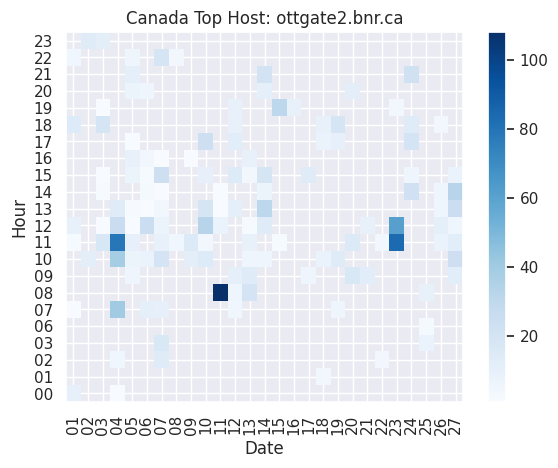

In [604]:
# count the number of visits on each date-hour combination
counts_ca = date_hours_pd_ca.groupby(['day', 'hour']).size().reset_index(name='count')

# create pivot table for heatmap
heatmap_data_ca = pd.pivot_table(counts_ca, values='count', index=['hour'], columns=['day'])

# plot heatmap
plt.pcolormesh(heatmap_data_ca, cmap='Blues')
plt.colorbar()
plt.title(f'Canada Top Host: {most_frequent_host_ca}')
plt.xlabel('Date')
plt.ylabel('Hour')
plt.xticks(np.arange(0.5, len(heatmap_data_ca.columns), 1), heatmap_data_ca.columns, rotation=90)
plt.yticks(np.arange(0.5, len(heatmap_data_ca.index), 1), heatmap_data_ca.index)
plt.savefig('Output/Q1_D_Can.png', dpi=400,bbox_inches='tight')
plt.show()

In [605]:
# group by host and count the number of occurrences
host_counts_sg = hosts_sg.select('host').groupBy('host').count().sort(desc('count'))

# extract the most frequent host
most_frequent_host_sg = host_counts_sg.first()['host']

# filter the original DataFrame based on the most frequent host
most_frequent_host_visits_sg = hosts_sg.filter(hosts_sg['host'] == most_frequent_host_sg)

# extract the times and hours of the visits
times_and_hours_sg =most_frequent_host_visits_sg.select(substring('timestamp', 1, 2).alias('day'), substring('timestamp', 13, 2).alias('hour'))

date_hours_pd_sg = times_and_hours_sg.toPandas()

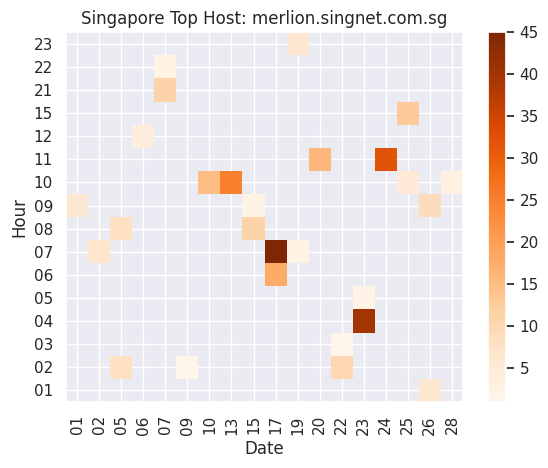

In [606]:
# count the number of visits on each date-hour combination
counts_sg = date_hours_pd_sg.groupby(['day', 'hour']).size().reset_index(name='count')

# create pivot table for heatmap
heatmap_data_sg = pd.pivot_table(counts_sg, values='count', index=['hour'], columns=['day'])

# plot heatmap
plt.pcolormesh(heatmap_data_sg, cmap='Oranges')
plt.colorbar()
plt.title(f'Singapore Top Host: {most_frequent_host_sg}')
plt.xlabel('Date')
plt.ylabel('Hour')
plt.xticks(np.arange(0.5, len(heatmap_data_sg.columns), 1), heatmap_data_sg.columns, rotation=90)
plt.yticks(np.arange(0.5, len(heatmap_data_sg.index), 1), heatmap_data_sg.index)
plt.savefig('Output/Q1_D_Sing.png', dpi=400,bbox_inches='tight')
plt.show()